In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

hyperparameter_df = pd.read_csv("./data/xgb_param_log.csv")
hyperparameter_df = hyperparameter_df[hyperparameter_df["challengers"] == False]
hyperparameter_df

,score,train_accuracy,test_accuracy,MAE,n_estimators,learning_rate,max_depth,subsample,colsample_bytree,min_child_weight,gamma,reg_alpha,reg_lambda,challengers,FILTER_NUM,iteration
0,0.646886,0.997085,0.640043,0.353114,267,0.186880,12,0.696092,0.724622,8,0.140902,0.356982,0.508925,False,0,1
1,0.652281,0.669812,0.662939,0.347719,35,0.003856,7,0.660851,0.978789,2,0.034280,0.229161,0.291764,False,0,2
2,0.657185,0.699698,0.667199,0.342815,28,0.001587,14,0.517585,0.629033,2,0.020340,8.281616,0.021894,False,0,3
3,0.664051,0.677781,0.670572,0.335949,159,0.031960,6,0.514113,0.521003,3,0.015359,4.792523,0.045328,False,0,4
4,0.667484,0.709994,0.671814,0.332516,263,0.020820,8,0.764740,0.934993,7,0.018798,0.076057,0.023182,False,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6891,0.655223,0.665421,0.659731,0.344777,68,0.001160,6,0.520398,0.897669,2,0.044769,0.498585,17.884884,False,80000,892
6892,0.659637,0.728181,0.651163,0.340363,297,0.001366,10,0.528057,0.831611,6,0.712131,0.030480,0.416442,False,80000,893
6893,0.649828,0.996069,0.629131,0.350172,263,0.069337,11,0.542716,0.728478,4,0.131114,1.066667,0.383712,False,80000,894
6894,0.655714,0.668256,0.660343,0.344286,245,0.006976,5,0.737720,0.737432,4,0.004594,0.000242,0.758729,False,80000,895


In [2]:
def plot_hyperparameter_effect(x, y, color_by=None, color_label=None, title=""):
    x = np.asarray(x)
    y = np.asarray(y)
    color_by = y if color_by is None else np.asarray(color_by)

    # Linear regression (ignore non-finite)
    mask = np.isfinite(x) & np.isfinite(y)
    a, b = np.polyfit(x[mask], y[mask], 1)
    r = np.corrcoef(x[mask], y[mask])[0, 1]

    # Plot
    sc = plt.scatter(x, y, c=color_by, cmap="viridis")
    # draw a straight line across the x-range
    xline = np.array([np.nanmin(x), np.nanmax(x)])
    plt.plot(xline, a * xline + b, color="red", label=f"y = {a:.2f}x + {b:.2f}")

    cbar = plt.colorbar(sc)
    cbar.set_label(color_label or "color")

    plt.title(f"Linear Regression (r = {r:.2f}) ({title})")
    plt.legend()
    plt.show()


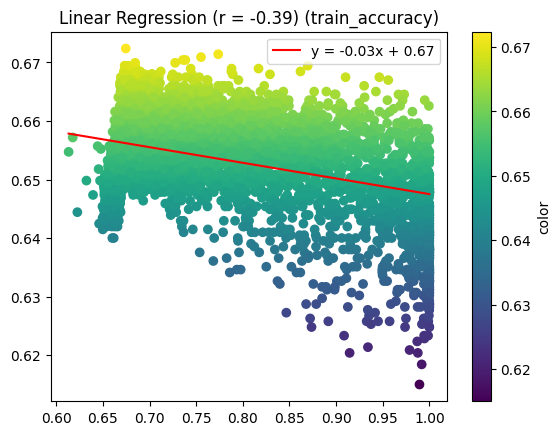

In [3]:
plot_hyperparameter_effect(
    hyperparameter_df["train_accuracy"].to_numpy(),
    hyperparameter_df["score"].to_numpy(),
    title="train_accuracy"
)

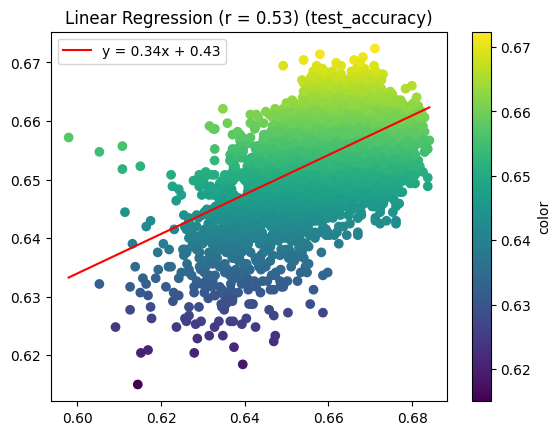

In [4]:
plot_hyperparameter_effect(
    hyperparameter_df["test_accuracy"].to_numpy(),
    hyperparameter_df["score"].to_numpy(),
    title="test_accuracy"
)

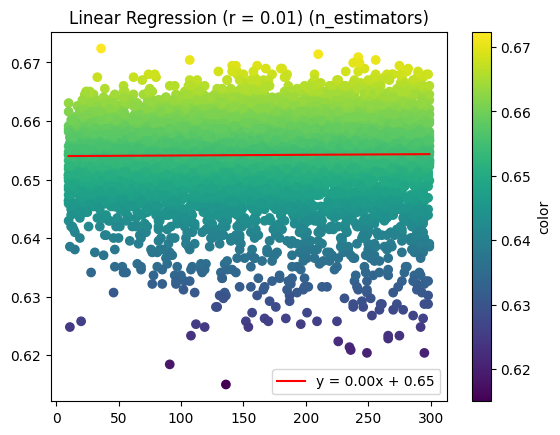

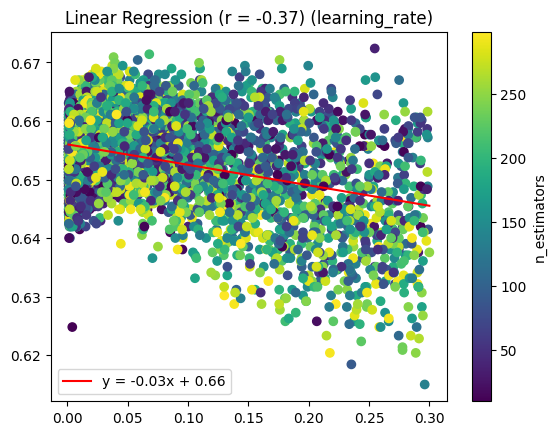

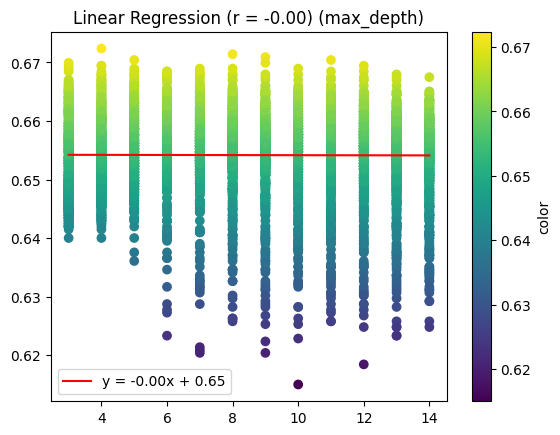

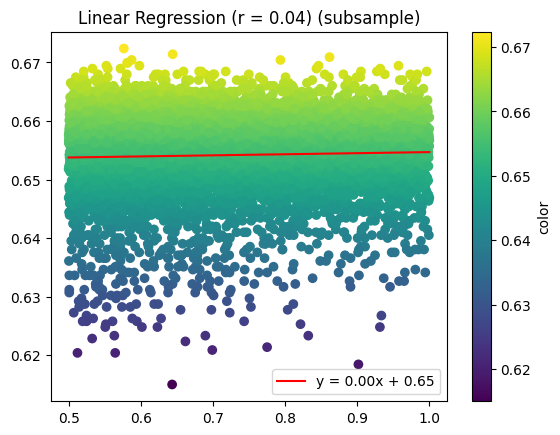

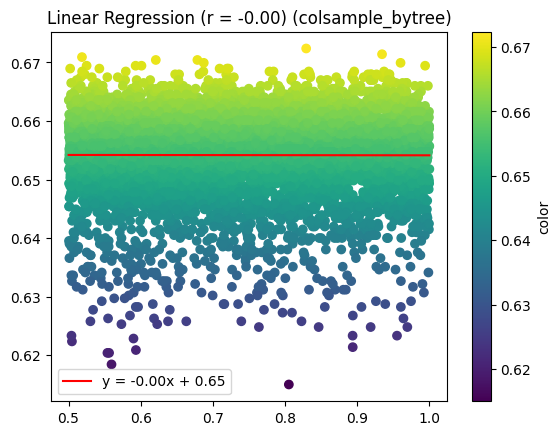

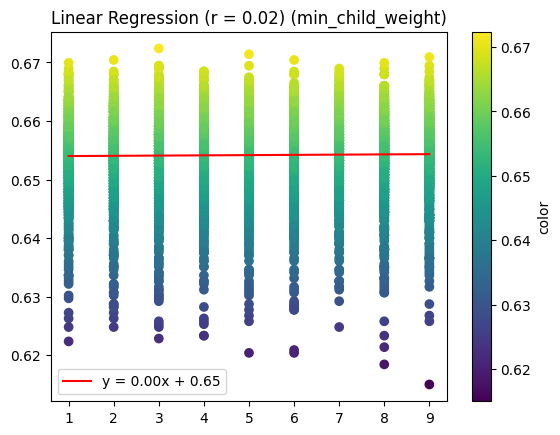

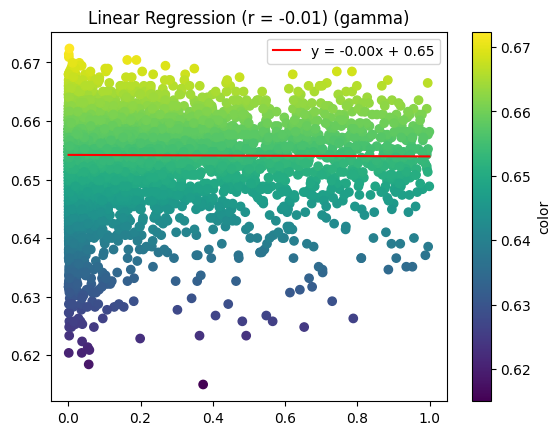

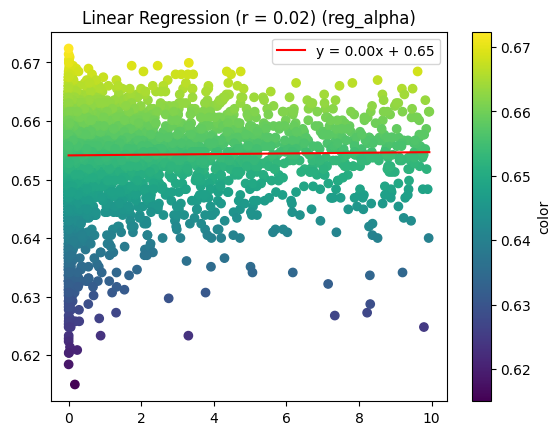

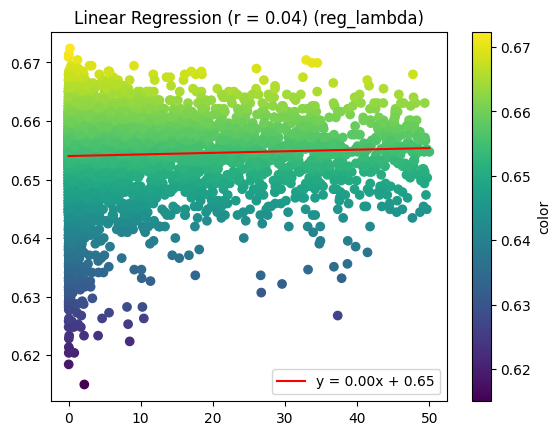

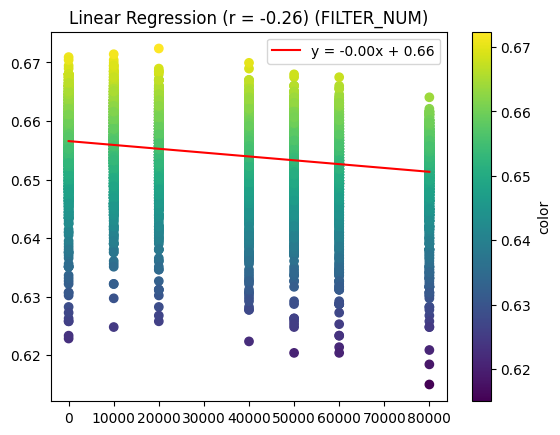

In [5]:
plot_hyperparameter_effect(
    hyperparameter_df["n_estimators"].to_numpy(),
    hyperparameter_df["score"].to_numpy(),
    title="n_estimators"
)

plot_hyperparameter_effect(
    hyperparameter_df["learning_rate"].to_numpy(),
    hyperparameter_df["score"].to_numpy(),
    color_by=hyperparameter_df["n_estimators"].to_numpy(),
    color_label="n_estimators",
    title="learning_rate"
)

plot_hyperparameter_effect(
    hyperparameter_df["max_depth"].to_numpy(),
    hyperparameter_df["score"].to_numpy(),
    title="max_depth"
)

plot_hyperparameter_effect(
    hyperparameter_df["subsample"].to_numpy(),
    hyperparameter_df["score"].to_numpy(),
    title="subsample"
)

plot_hyperparameter_effect(
    hyperparameter_df["colsample_bytree"].to_numpy(),
    hyperparameter_df["score"].to_numpy(),
    title="colsample_bytree"
)

plot_hyperparameter_effect(
    hyperparameter_df["min_child_weight"].to_numpy(),
    hyperparameter_df["score"].to_numpy(),
    title="min_child_weight"
)

plot_hyperparameter_effect(
    hyperparameter_df["gamma"].to_numpy(),
    hyperparameter_df["score"].to_numpy(),
    title="gamma"
)

plot_hyperparameter_effect(
    hyperparameter_df["reg_alpha"].to_numpy(),
    hyperparameter_df["score"].to_numpy(),
    title="reg_alpha"
)

plot_hyperparameter_effect(
    hyperparameter_df["reg_lambda"].to_numpy(),
    hyperparameter_df["score"].to_numpy(),
    title="reg_lambda"
)

plot_hyperparameter_effect(
    hyperparameter_df["FILTER_NUM"].to_numpy(),
    hyperparameter_df["score"].to_numpy(),
    title="FILTER_NUM"
)

It seems like the more data the best the model works. Hence, let's give it all data except the first 10000 rows. This means I'll train the XGBoost with all data expect the first 10000 matches (this is better than including even more data, because at the beggining of those 10k matches, the ELO ratings are still not stable).

In [6]:
almost_all_data = hyperparameter_df[hyperparameter_df["FILTER_NUM"] == 10000]
almost_all_data = hyperparameter_df[hyperparameter_df["n_estimators"] >= 250]
almost_all_data

,score,train_accuracy,test_accuracy,MAE,n_estimators,learning_rate,max_depth,subsample,colsample_bytree,min_child_weight,gamma,reg_alpha,reg_lambda,challengers,FILTER_NUM,iteration
0,0.646886,0.997085,0.640043,0.353114,267,0.186880,12,0.696092,0.724622,8,0.140902,0.356982,0.508925,False,0,1
4,0.667484,0.709994,0.671814,0.332516,263,0.020820,8,0.764740,0.934993,7,0.018798,0.076057,0.023182,False,0,5
8,0.655223,0.696298,0.670749,0.344777,258,0.001687,14,0.699980,0.691149,7,0.057395,5.216955,31.683053,False,0,9
11,0.662580,0.762488,0.669684,0.337420,267,0.064873,8,0.814006,0.585922,9,0.383013,0.032603,4.172401,False,0,12
12,0.649828,0.662899,0.660987,0.350172,254,0.001031,5,0.727260,0.681017,5,0.003753,0.000312,0.039424,False,0,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6882,0.656204,0.812719,0.647491,0.343796,289,0.011780,9,0.747246,0.630125,2,0.013503,0.003080,0.092176,False,80000,883
6889,0.644924,0.916847,0.651163,0.355076,279,0.060642,8,0.685628,0.974776,5,0.010085,0.003720,0.335706,False,80000,890
6890,0.654733,0.752151,0.654835,0.345267,295,0.003900,11,0.601733,0.691484,9,0.002122,2.344938,0.082521,False,80000,891
6892,0.659637,0.728181,0.651163,0.340363,297,0.001366,10,0.528057,0.831611,6,0.712131,0.030480,0.416442,False,80000,893


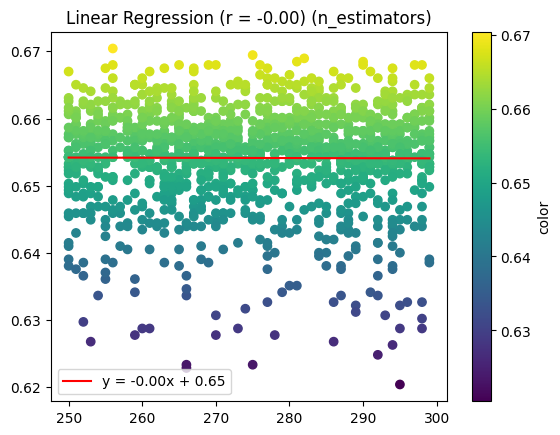

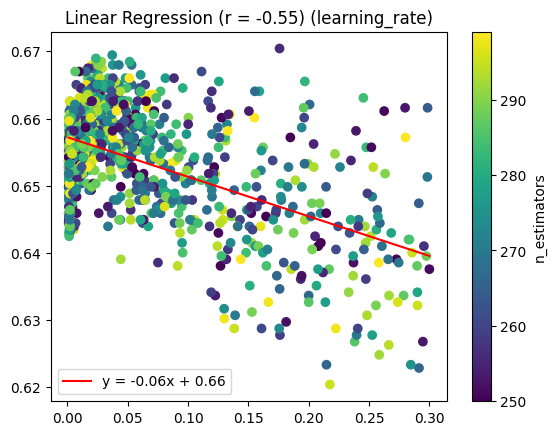

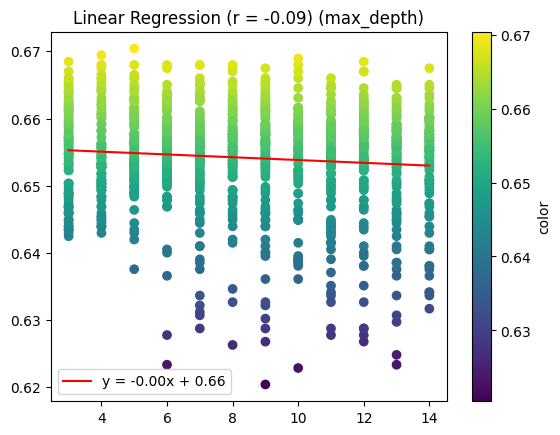

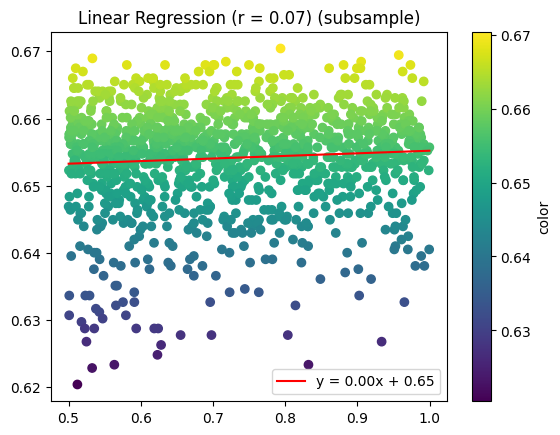

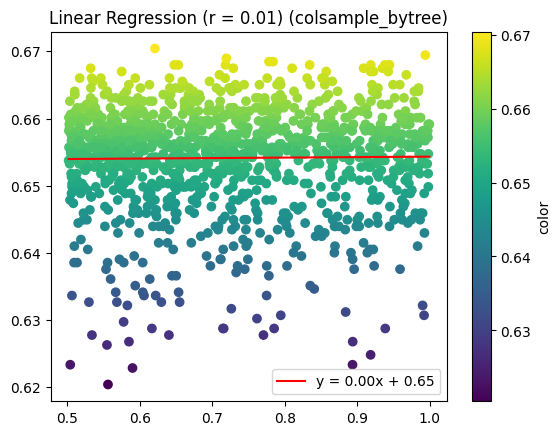

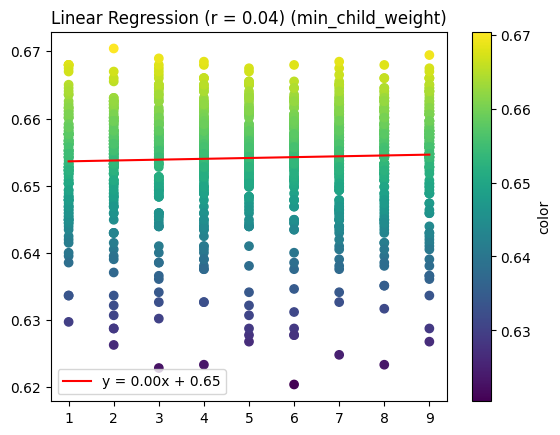

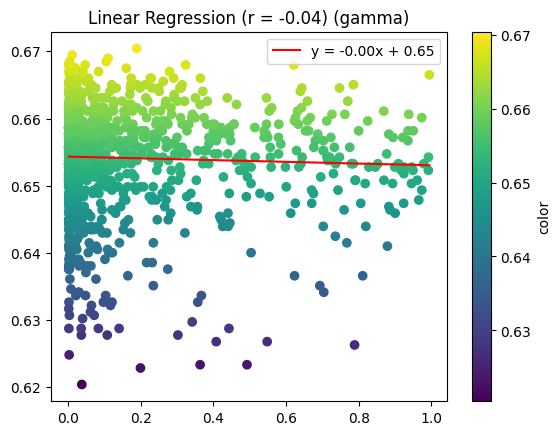

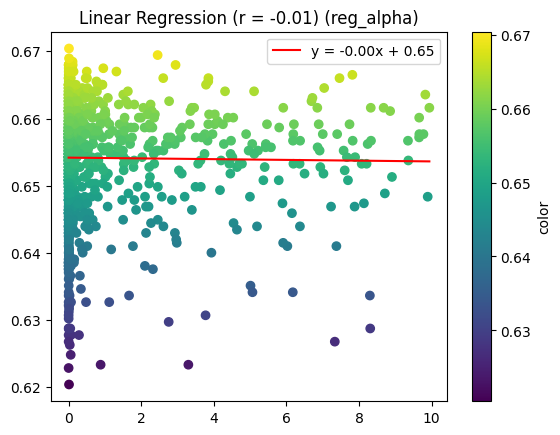

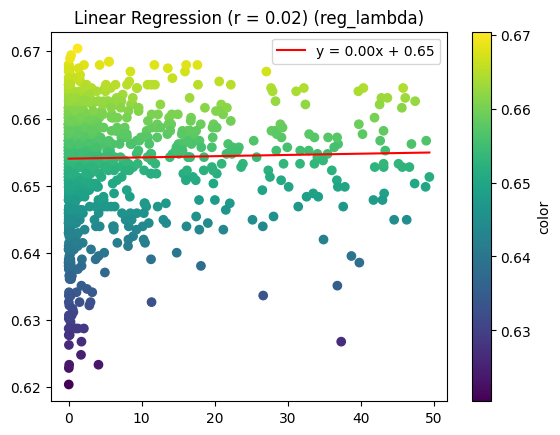

In [7]:
plot_hyperparameter_effect(
    almost_all_data["n_estimators"].to_numpy(),
    almost_all_data["score"].to_numpy(),
    title="n_estimators"
)

plot_hyperparameter_effect(
    almost_all_data["learning_rate"].to_numpy(),
    almost_all_data["score"].to_numpy(),
    color_by=almost_all_data["n_estimators"].to_numpy(),
    color_label="n_estimators",
    title="learning_rate"
)

plot_hyperparameter_effect(
    almost_all_data["max_depth"].to_numpy(),
    almost_all_data["score"].to_numpy(),
    title="max_depth"
)

plot_hyperparameter_effect(
    almost_all_data["subsample"].to_numpy(),
    almost_all_data["score"].to_numpy(),
    title="subsample"
)

plot_hyperparameter_effect(
    almost_all_data["colsample_bytree"].to_numpy(),
    almost_all_data["score"].to_numpy(),
    title="colsample_bytree"
)

plot_hyperparameter_effect(
    almost_all_data["min_child_weight"].to_numpy(),
    almost_all_data["score"].to_numpy(),
    title="min_child_weight"
)

plot_hyperparameter_effect(
    almost_all_data["gamma"].to_numpy(),
    almost_all_data["score"].to_numpy(),
    title="gamma"
)

plot_hyperparameter_effect(
    almost_all_data["reg_alpha"].to_numpy(),
    almost_all_data["score"].to_numpy(),
    title="reg_alpha"
)

plot_hyperparameter_effect(
    almost_all_data["reg_lambda"].to_numpy(),
    almost_all_data["score"].to_numpy(),
    title="reg_lambda"
)

In [8]:
hyperparameter_df[hyperparameter_df["n_estimators"] > 200]

,score,train_accuracy,test_accuracy,MAE,n_estimators,learning_rate,max_depth,subsample,colsample_bytree,min_child_weight,gamma,reg_alpha,reg_lambda,challengers,FILTER_NUM,iteration
0,0.646886,0.997085,0.640043,0.353114,267,0.186880,12,0.696092,0.724622,8,0.140902,0.356982,0.508925,False,0,1
4,0.667484,0.709994,0.671814,0.332516,263,0.020820,8,0.764740,0.934993,7,0.018798,0.076057,0.023182,False,0,5
8,0.655223,0.696298,0.670749,0.344777,258,0.001687,14,0.699980,0.691149,7,0.057395,5.216955,31.683053,False,0,9
9,0.650809,0.986977,0.648030,0.349191,208,0.220725,10,0.877165,0.919978,2,0.936275,0.344165,2.676063,False,0,10
10,0.656204,0.665729,0.661874,0.343796,215,0.001011,6,0.605269,0.841909,5,0.002275,0.003705,5.149844,False,0,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6889,0.644924,0.916847,0.651163,0.355076,279,0.060642,8,0.685628,0.974776,5,0.010085,0.003720,0.335706,False,80000,890
6890,0.654733,0.752151,0.654835,0.345267,295,0.003900,11,0.601733,0.691484,9,0.002122,2.344938,0.082521,False,80000,891
6892,0.659637,0.728181,0.651163,0.340363,297,0.001366,10,0.528057,0.831611,6,0.712131,0.030480,0.416442,False,80000,893
6893,0.649828,0.996069,0.629131,0.350172,263,0.069337,11,0.542716,0.728478,4,0.131114,1.066667,0.383712,False,80000,894


In [9]:
hyperparameter_df[hyperparameter_df["n_estimators"] > 200].sort_values("score", ascending=False).head(50)

,score,train_accuracy,test_accuracy,MAE,n_estimators,learning_rate,max_depth,subsample,colsample_bytree,min_child_weight,gamma,reg_alpha,reg_lambda,challengers,FILTER_NUM,iteration
1765,0.671408,0.773609,0.657966,0.328592,210,0.067849,8,0.644214,0.934395,5,0.001357,0.000454,0.036356,False,10000,766
111,0.670917,0.755173,0.668264,0.329083,242,0.038251,9,0.861610,0.518590,9,0.001681,0.029029,0.011198,False,0,112
1157,0.670427,0.735808,0.654071,0.329573,256,0.175810,5,0.793555,0.620902,2,0.188483,0.009362,1.236999,False,10000,158
1611,0.669936,0.727412,0.661862,0.330064,238,0.039446,9,0.581008,0.687374,8,0.030492,3.311504,33.733933,False,10000,612
3814,0.669936,0.684526,0.667584,0.330064,243,0.109083,3,0.581865,0.960074,1,0.011949,0.005318,34.469565,False,40000,815
39,0.669446,0.673287,0.670927,0.330554,275,0.037127,4,0.957210,0.994106,9,0.010615,2.452710,0.355006,False,0,40
1755,0.668955,0.744041,0.657187,0.331045,247,0.038305,8,0.843486,0.542693,3,0.348893,0.060358,0.429709,False,10000,756
3044,0.668955,0.816843,0.666758,0.331045,282,0.023602,10,0.533037,0.719565,3,0.109529,0.011005,0.199680,False,40000,45
1852,0.668465,0.689909,0.659135,0.331535,242,0.023196,7,0.520922,0.832917,2,0.006748,2.061915,17.000201,False,10000,853
1164,0.668465,0.672439,0.661083,0.331535,281,0.051534,3,0.905141,0.784026,7,0.003574,0.063359,5.520199,False,10000,165


## Test if including Qualifiers works better

In [10]:
hyperparameter_df_all = pd.read_csv("./data/xgb_param_log.csv")
hyperparameter_df_all = hyperparameter_df_all[hyperparameter_df_all["FILTER_NUM"] == 10000]
hyperparameter_df_all

,score,train_accuracy,test_accuracy,MAE,n_estimators,learning_rate,max_depth,subsample,colsample_bytree,min_child_weight,gamma,reg_alpha,reg_lambda,challengers,FILTER_NUM,iteration
1000,0.653261,0.748880,0.664979,0.346739,95,0.002404,14,0.541644,0.503580,5,0.006450,0.002333,1.197294,False,10000,1
1001,0.656694,0.702734,0.661083,0.343306,232,0.001199,10,0.953239,0.521617,8,0.321391,0.268734,3.087281,False,10000,2
1002,0.653752,0.726622,0.659914,0.346248,31,0.007633,12,0.563815,0.720653,5,0.013430,0.532155,1.476734,False,10000,3
1003,0.655714,0.673167,0.657577,0.344286,47,0.090473,5,0.785642,0.782525,2,0.229677,6.454739,0.266722,False,10000,4
1004,0.658166,0.722778,0.661667,0.341834,62,0.003730,12,0.888882,0.567276,8,0.019392,0.702122,6.292894,False,10000,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8546,0.653752,0.677008,0.653829,0.346248,84,0.013424,10,0.947122,0.606364,8,0.492913,8.010180,8.390468,True,10000,1651
8547,0.653752,0.655253,0.653057,0.346248,394,0.006822,4,0.823232,0.513881,4,0.763547,4.489952,17.627870,True,10000,1652
8548,0.663561,0.664754,0.657029,0.336439,471,0.031398,4,0.617664,0.706565,5,0.026083,3.985493,0.129698,True,10000,1653
8549,0.665032,0.669493,0.660561,0.334968,135,0.057147,6,0.628896,0.768419,3,0.005245,4.070919,1.113999,True,10000,1654


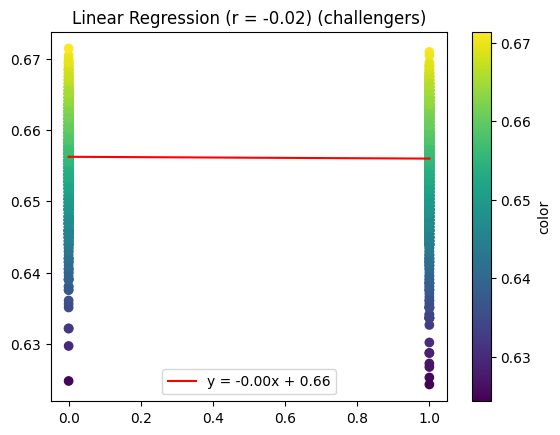

In [11]:
plot_hyperparameter_effect(
    hyperparameter_df_all["challengers"].to_numpy(),
    hyperparameter_df_all["score"].to_numpy(),
    title="challengers"
)

Now, in this case, the linear regression indicates a negative correlation, it seems like not including the qualifiers in the training data works better. It also seems that not having the qualifiers in the training data has a higher peak.

# HyperParamters with New Model

In [12]:
hyperparameter_df = pd.read_csv("./data/final_xgb_param_log.csv")
hyperparameter_df = hyperparameter_df[hyperparameter_df["challengers"] == False]
hyperparameter_df

,iteration,n_estimators,learning_rate,max_depth,subsample,colsample_bytree,gamma,reg_alpha,reg_lambda,k_factor,...,max_k_factor,div_number,bonus_after_layoff,filter_num,challengers,MODEL_NAME,train_accuracy,test_accuracy,score2025,mae2025
0,1,264,0.019457,3,0.935804,0.974848,0.046657,3.409933,0.507778,NaN,...,62,800,False,10000,False,best_final_xgb_model,0.669835,0.653487,0.670274,0.329726
1,2,264,0.007775,6,0.911715,0.898051,0.177058,0.440696,8.001818,NaN,...,62,800,False,10000,False,best_final_xgb_model,0.675966,0.667511,0.666667,0.333333
2,3,77,0.002348,3,0.910481,0.999726,0.031675,0.326582,0.023908,NaN,...,62,800,False,10000,False,best_final_xgb_model,0.654794,0.655434,0.657287,0.342713
3,4,156,0.039385,5,0.843757,0.869787,0.085695,0.000475,0.042015,NaN,...,62,800,False,10000,False,best_final_xgb_model,0.681184,0.670432,0.664502,0.335498
4,5,59,0.036224,8,0.980993,0.818921,0.078103,0.000512,0.032951,NaN,...,62,800,False,10000,False,best_final_xgb_model,0.701217,0.654850,0.668831,0.331169
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
321,322,228,0.060452,7,0.967582,0.855041,0.012241,0.000194,1.708663,NaN,...,62,800,False,10000,False,best_final_xgb_model,0.748521,0.666732,0.669553,0.330447
322,323,438,0.015152,8,0.867200,0.835866,0.059745,0.009332,3.515894,NaN,...,62,800,False,10000,False,best_final_xgb_model,0.734475,0.660499,0.670274,0.329726
323,324,410,0.002831,3,0.801003,0.985320,0.022430,0.006640,0.118536,NaN,...,62,800,False,10000,False,best_final_xgb_model,0.661807,0.674718,0.660173,0.339827
324,325,335,0.016033,5,0.805624,0.928434,0.134965,0.606612,2.640652,NaN,...,62,800,False,10000,False,best_final_xgb_model,0.678887,0.674718,0.665945,0.334055


In [13]:
hyperparameter_df.sort_values("score2025")

,iteration,n_estimators,learning_rate,max_depth,subsample,colsample_bytree,gamma,reg_alpha,reg_lambda,k_factor,...,max_k_factor,div_number,bonus_after_layoff,filter_num,challengers,MODEL_NAME,train_accuracy,test_accuracy,score2025,mae2025
14,15,177,0.002640,4,0.981763,0.876120,0.087972,0.245946,0.089489,NaN,...,62,800,False,10000,False,best_final_xgb_model,0.663099,0.651344,0.651515,0.348485
69,70,283,0.071851,9,0.819206,0.845254,0.018279,0.770616,0.152079,NaN,...,62,800,False,10000,False,best_final_xgb_model,0.948175,0.663810,0.652237,0.347763
158,159,430,0.002146,4,0.963609,0.927479,0.795971,1.159604,31.494801,NaN,...,62,800,False,10000,False,best_final_xgb_model,0.665580,0.658161,0.653680,0.346320
292,293,128,0.007231,4,0.903817,0.866278,0.029732,0.546510,14.575490,NaN,...,62,800,False,10000,False,best_final_xgb_model,0.665754,0.666732,0.653680,0.346320
198,199,273,0.099364,9,0.901244,0.880634,0.351211,0.415461,0.563457,NaN,...,62,800,False,10000,False,best_final_xgb_model,0.966752,0.649201,0.654401,0.345599
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15,16,283,0.022283,9,0.907687,0.972286,0.041322,0.000162,5.606709,NaN,...,62,800,False,10000,False,best_final_xgb_model,0.766493,0.655045,0.673882,0.326118
282,283,389,0.017259,6,0.957018,0.864378,0.393524,0.695647,0.108998,NaN,...,62,800,False,10000,False,best_final_xgb_model,0.692605,0.679392,0.674603,0.325397
88,89,152,0.040148,8,0.801057,0.951018,0.042542,0.000446,0.113103,NaN,...,62,800,False,10000,False,best_final_xgb_model,0.739817,0.666147,0.674603,0.325397
162,163,430,0.011361,8,0.831964,0.990521,0.199711,2.327430,0.041850,NaN,...,62,800,False,10000,False,best_final_xgb_model,0.723198,0.664589,0.676046,0.323954


After observing all the plots and training rounds I decided to set the final hyperparameters to the following:

```
params = {
    "n_estimators": 250,
    "learning_rate": 0.04,
    "max_depth": 5,
    "subsample": 0.9,
    "colsample_bytree": 0.95,
    "gamma": 0.2,
    "reg_alpha": 0.5,
    "reg_lambda": 5,
}
```